This notebook takes borehole data from the East Kimberley, interpolates/ averages the data so that it they can be formulated as a sample vs feature array. This array can be used to investigate correlations between datasets, impute the array  and be used as training data for interpretations at boreholes

Neil Symington
neil.symington@ga.gov.au

In [2]:
%matplotlib inline


In [3]:
from sqlite3 import dbapi2 as sqlite
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
import os
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import yaml
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def search(kword_dict, word):
    """
    A search function for finding if a keword
    exists as a list element within a dictionary entry
    
    @param kword_dict: dictionary with keywords
    @word: string
    returns
    the key for the entry if it exists or None if not
    """
    word = word.lower()
    for k in kword_dict:
        for v in kword_dict[k]:
            if word in v:
                return k
    return None



In [5]:
# First we bring in polygons for the project area

gdf = gpd.read_file(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\Keep_spatial\Keep_River_polygons.shp")

# Visualise the palaeovalley extent as defined by the magnetics
#gdf.loc[[0],'geometry'].plot()

# Create a unary union so we can query our spatially query the bores
OrdKeep = gdf.geometry.unary_union.wkt
#OrdKeep = gdf['geometry'].iloc[0].wkt


In [6]:
# Extract data from the database

path = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite"

DB_PATH = os.path.join(path, "East_Kimberley_Boreholes.sqlite")

SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()


In [7]:
df_header = borehole_utils.extract_boreholes_within_geometry('borehole', connection,
                                                             OrdKeep, columns = 'all')

Select b.* from borehole b  where within(b.geom,GeomFromText('POLYGON ((503725.1616292503 8365005.710026997, 503797.9112354947 8365049.777662147, 545533.9824877982 8363955.027693332, 555824.2588038964 8337896.865118176, 558946.0197683489 8337454.919065265, 557778.2797407188 8337239.809060173, 556205.879152536 8336930.4843543, 557487.5911249644 8333684.793186628, 557496.2158347503 8333662.952753694, 544392.6445761472 8283029.217971241, 544357.8626615324 8282894.816577523, 503524.2702587695 8237140.634983661, 448598.5557859408 8240759.81529371, 448510.4090386229 8240765.623483469, 473911.8997739411 8299766.09539283, 473902.8962494675 8299786.129389727, 457250.0834351546 8336857.594840728, 503725.1616292503 8365005.710026997))'));


In [10]:
# First import all the datasets based on our enos (primary key)

enos = df_header.borehole_id.values


df_bNMR = borehole_utils.extract_sql_with_primary_key("boreholeNMR_data", ['Depth', 'Total_water_content',
                                                'Clay_water_content', 'Capillary_water_content',
                                               'Free_water_content', 'K_SDR', 'borehole_id'], connection, enos)

df_lithology = borehole_utils.extract_sql_with_primary_key("borehole_lithology", ['Depth_from', 'Depth_to',
                                                'Lithology_name', 'Lithology_description',
                                                           'borehole_id'], connection, enos)

# We have an issue with lithology having duplicate entries for the same interval
# For now we are just going to keep the first entry

df_lithology = df_lithology[~df_lithology.duplicated(subset = ["Depth_from", "borehole_id"],
                                       keep = 'first')]

# Classify the lithology using a yaml file keyword lookup table
yaml_file = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\classification\hydclass_classification.yml"

with open(yaml_file) as f:
    # use safe_load instead load
    hyd_class = yaml.safe_load(f)


# Assign all rows to a class of 7 which is the unkown class
df_lithology['hydraulic_class'] = 7

# iterate through lithology names
for index, row in df_lithology.iterrows():
    lithname = row.Lithology_name
    
    # Add the classification integer to the dataframe if it is found
    interval_class = search(hyd_class, lithname)
    
    if interval_class is not None:
        df_lithology.at[index, 'hydraulic_class']
    else:
        # Otherwise we can add it to the yaml file
        print(lith_name)
    
    

df_indgam = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Conductivity','Gamma_calibrated',
                                                         'GR','borehole_id'], connection, enos)

df_EC_pH = borehole_utils.extract_sql_with_primary_key("pore_fluid_EC_pH", 
                                                       ['Depth', 'EC', 'pH', 'borehole_id'],
                                                       connection, enos)


select t.Depth, t.Total_water_content, t.Clay_water_content, t.Capillary_water_content, t.Free_water_content, t.K_SDR, t.borehole_id from boreholeNMR_data t where t.borehole_id in (621622,621623,626981,626984,626986,626987,626988,626989,626990,626991,626992,627061,627063,627064,628981,635728,635729,635730,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635744,635745,635746,635921,635922,635923,635957,635958,635959,635960,636181,636182,636183,636184,636185,636186,636188,636189,636190,636191,636193,636194,636195,636196,636197,636198,636200,636201,636204,636205);
select t.Depth_from, t.Depth_to, t.Lithology_name, t.Lithology_description, t.borehole_id from borehole_lithology t where t.borehole_id in (621622,621623,626981,626984,626986,626987,626988,626989,626990,626991,626992,627061,627063,627064,628981,635728,635729,635730,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635744,635745,635746,635921,635922,635923,63595

In [11]:
# Our first investigation will be looking at relationships between these borehole data 
# and the AEM

# load AEM

nc_dir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\netcdf"

ek_cond = netCDF4.Dataset(os.path.join(nc_dir, "OrdKeep2019_ModeExp_cor2DLogOrd.nc"))

# Create an instance of point utils

cond_point_util = NetCDFPointUtils(ek_cond)

wkt, aem_coords = cond_point_util.utm_coords(cond_point_util.xycoords)

In [12]:
# For every bore we will find the distance and netcdf
# index for each borehole that is within 1 km of an AEM fiducial

distances, indices = spatial_functions.nearest_neighbours(df_header[['Easting','Northing']], aem_coords,
                                                        points_required = 10, max_distance = 1000.)

In [13]:
# Here we will create a table of AEM conductivity profiles for each
# borehole. To guard against anomolour points we will take an inverse
# distance weighting of conductivity from the 10 closest points

# REsults are written into a dataframe

df_conductivity = pd.DataFrame(columns = {'borehole_id',
                                          'Depth_from',
                                          'Depth_to',
                                          'conductivity'})

# Create a flag for if there is AEM data for the borehole

df_header['AEM_proximal'] = 0

for i, (index, row) in enumerate(df_header.iterrows()):
    # If the distances are not infinite (i.e. the boreholes disatnce is greater
    # than the maximum)
    if np.isfinite(np.sum(distances[i])):
        
        # Extract a representative profile
        df_conductivity_profile = AEM_utils.extract_conductivity_profile(ek_cond,
                                                   distances[i], indices[i],
                                                   as_dataframe = True,
                                                  mask_below_doi=True)
        
        df_conductivity_profile['borehole_id'] = row.borehole_id

        # Append it to the dataframe
        df_conductivity = df_conductivity.append(df_conductivity_profile)
        
        # Update the flag
        df_header.at[index, 'AEM_proximal'] = 1 


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [14]:
# Spit out this as a csv

outfile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\AEM\borhole_interpolated_AEM_profiles.csv"

df_conductivity.to_csv(outfile, index=False)

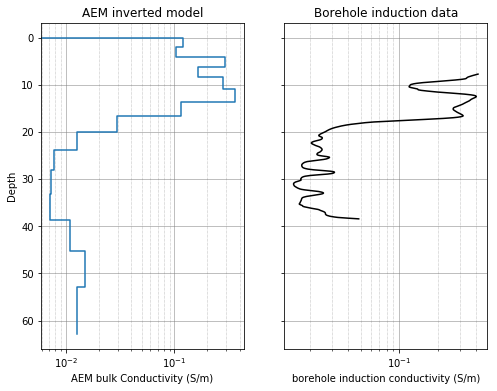

In [15]:
# Lets do a quick visual analysis of borehole induction vs AEM for outrsites

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\AEM_vs_induction_plots"

for index, row in df_header.iterrows():
    
    if (row['AEM_proximal'] == 1) & (row['Induction_acquired'] == 1):
        
        fig, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (8,6))
        
        # Extract the data using eno
        
        eno = row['borehole_id']
        
        
        # Extract induction
        
        indmask = df_indgam['borehole_id'] == eno
        
        induction_profile = df_indgam[indmask]['Conductivity'].values
        
        depth = df_indgam[indmask]['Depth'].values
        
        ax2 = plotting_utils.plot_downhole_log(ax2, induction_profile,
                                  depth,log_plot=True)
        
        # Extract AEM conductivity
        condmask = df_conductivity['borehole_id'] == eno
        
        conductivity_profile = df_conductivity[condmask]['conductivity'].values
        
        depth_top= df_conductivity[condmask]['Depth_from'].values
        
        
        # So the plots are on a similar scale we clip the conductivity to
        # the depth of the bore + 20 m
        
        depth_mask = depth_top < (np.max(depth) + 20.) 
        
        ax1 = plotting_utils.plot_AEM_conductivity_profile(ax1, conductivity_profile[depth_mask],
                                  depth_top[depth_mask], doi=None, log_plot=True)
        
        
        ax1.set_title("AEM inverted model")
        ax1.set_ylabel("Depth")
        ax1.set_xlabel("AEM bulk Conductivity (S/m)")
        ax2.set_title("Borehole induction data")

        ax2.set_xlabel("borehole induction conductivity (S/m)")
        #plt.savefig(os.path.join(outdir, row['Borehole_name'] + "_conductivity_vs_induction.png"))
        
        if index == df_header[df_header['Borehole_name'] == 'RN040310'].index:
            plt.show()
        
        plt.close()
        

In [17]:
# Now lets try interpolating all data onto the lithology intervals

df_subset = df_header[df_header['Lithology_available'] == 1]

# The data will be appended to a dataframe called interpolated

df_interpolated = pd.DataFrame(columns = ['Depth_from', 'Depth_to', 'hydraulic_class',
                                         'AEM_conductivity', 'induction', 'GR',
                                         "EC", 'pH'])

# Iterate through the bores

for index, row in df_subset.iterrows():
    
    # First we want to find the min and max depth for the boreholes
    eno = row.borehole_id
    
    df_ = borehole_utils.extract_by_primary_key(df_conductivity, eno)
    print(df_)
    break
    # Get the intervals onto which the other datasets will be interpolated
    
    
    

    Depth_from  Depth_to borehole_id  conductivity
0     0.000000       2.0      635728      0.160000
1     2.000000       4.3      635728      0.228154
2     4.300000       6.8      635728      0.369549
3     6.800000       9.7      635728      0.903342
4     9.700000      12.9      635728      0.878735
5    12.900000      16.6      635728      0.483092
6    16.600000      20.7      635728      0.470367
7    20.700001      25.4      635728      0.774593
8    25.400000      30.6      635728      1.011122
9    30.600000      36.5      635728      0.734754
10   36.500000      43.2      635728      0.471254
11   43.200001      50.7      635728      0.315557
12   50.700001      59.2      635728      0.272183
13   59.200001      68.8      635728      0.299133
14   68.800003      79.6      635728      0.281849
15   79.599998      91.8      635728      0.181719
16   91.800003     105.6      635728      0.098184
17  105.599998     121.1      635728      0.059898
18  121.099998     138.6      6

In [93]:
subset_enos = df_subset.borehole_id.values

subset_enos

array([635728, 635730, 635734, 635735, 635737, 635738, 635739, 635740,
       635741, 635742, 635743, 635746, 635747, 635748], dtype=int64)

In [95]:
df_indgam[df_indgam['borehole_id'] in subset_enos]

ValueError: Lengths must match to compare

In [101]:
mask = df_indgam['borehole_id'].isin([635728])

814